<a href="https://colab.research.google.com/github/BioGeMT/DLforGenomics/blob/dev/notebooks/2D_binding_matrix_and_2D_convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Change runtime to GPU/TPU.

## Imports

In [1]:
from tensorflow import keras as K
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve

## Helper functions

In [2]:
def compile_model(
      model,
      learning_rate = 0.001):

    optimizer = K.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [3]:
def plot_history(history):
    """
    fun plots history of the training of the model,
    accuracy and loss of the training and validation set

    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    axes[0].plot(epochs, acc)
    axes[0].plot(epochs, val_acc)
    axes[0].set_title('Accuracy')

    axes[1].plot(epochs, loss, label='Training')
    axes[1].plot(epochs, val_loss, label='Validation')
    axes[1].set_title('Loss')

    fig.legend(loc='center right', bbox_to_anchor=(1.1, 0.5))
    fig.tight_layout()

    plt.show()

## Downloads

In [4]:
!wget https://raw.githubusercontent.com/BioGeMT/DLforGenomics/main/data/Helwak_2013/all_miRNA/miRNA_train_set.tsv -O miRNA_train_set.tsv

--2024-05-31 14:03:42--  https://raw.githubusercontent.com/BioGeMT/DLforGenomics/main/data/Helwak_2013/all_miRNA/miRNA_train_set.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2424789 (2.3M) [text/plain]
Saving to: ‘miRNA_train_set.tsv’

miRNA_train_set.tsv 100%[===================>]   2.31M  --.-KB/s    in 0.05s   

2024-05-31 14:03:43 (47.1 MB/s) - ‘miRNA_train_set.tsv’ saved [2424789/2424789]



# Data preparation

In [5]:
df = pd.read_csv('miRNA_train_set.tsv', sep='\t')
df

,noncodingRNA,gene,label
0,TGTAAACATCCTCGACTGGA,GTCGAGAAGTCAACGACTCAATGAAGAATTCCACTTATGGCGTGAA...,1
1,TGAGACCTCTGGGTTCTGAG,GACCTCAGAGCTCCAGGATCATCAGTAAATTTGTCATGTTATATAT...,1
2,GAGGGTTGGGTGGAGGCTCT,TGCCATAATGAACCGTCCAGCCCCTGTGGAGATCTCCTATGAGAAC...,1
3,CAAAGTGCTTACAGTGCAGG,CACCAGAATTGCCAAAGCACATATATAATAAATTAGATAAAGGGCA...,1
4,TTAGGGCCCTGGCTCCATCT,AGCCAAGTGGAGAAGGGTTCCTATCCCTGGCAGGTATCTCTGAAAC...,1
...,...,...,...
32779,CGGGCGTGGTGGTGGGGG,CTTCTTCACTGACTCTTGTCCAGATGCCCTGTTTAATGAACTGGTA...,0
32780,AAAGTGCTTCCCTTTGGACT,TGCTCCAGAAACTGCCAGTGCCCCTCTCTCAATGGATGACCCATCT...,0
32781,CCTGTTCTCCATTACTTGGC,TGACAGTGCCACATACTGCGGACCAAGGGACTCCAATCTGGTAATG...,0
32782,TCAGGCTCAGTCCCCTCCCG,GCACCTGAAGAAACCTGGGGGCTTTGACATATCCTTGTTCTACAGA...,0


In this notebook, we are no longer working with one sequences, but with pairs of sequences. To encode pair of sequences for neural network, we will use 2D-binding matrix technique introduced in the paper [miRBind: A Deep Learning Method for miRNA Binding Classification](https://doi.org/10.3390/genes13122323).
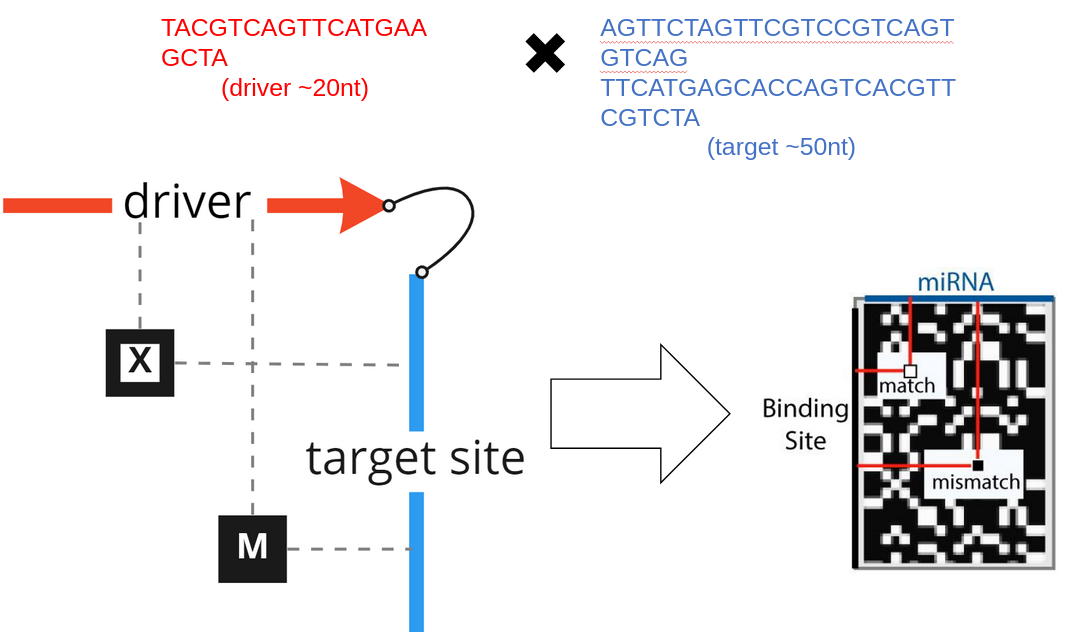

2D-binding matrix has rows corresponding to the binding site nucleotides and columns corresponding to the miRNA nucleotides. Matrix is filled with the while pixes, if given nucleotides for a Watson-Crick pairing and with the black pixel otherwise.

We can use `binding_encoding(df, tensor_dim)` function to do this transformation. Output has dimensions (1, 50, 20, 1), where

- the first dimension is number of samples,
- the second dimension is number of rows
- the third dimension is number of columns, and
- the fourth dimension is number of channels in the image, which is 1 in our case.


In [6]:
def binding_encoding(df, miRNA_col, gene_col, tensor_dim=(50, 20, 1)):
    """
    fun encodes miRNAs and mRNAs in df into binding matrices
    :param df: dataframe containing 'gene' and 'miRnoncodingRNANA' columns
    :param tensor_dim: output shape of the matrix
    :return: data encoded as 2D-binding matrix
    """

    # alphabet for watson-crick interactions.
    alphabet = {"AT": 1., "TA": 1., "GC": 1., "CG": 1.}
    # create empty main 2d matrix array
    N = df.shape[0]  # number of samples in df
    shape_matrix_2d = (N, *tensor_dim)  # 2d matrix shape
    # initialize dot matrix with zeros
    binding_matrix_2d = np.zeros(shape_matrix_2d, dtype="float32")

    # compile matrix with watson-crick interactions.
    for index, row in df.iterrows():
        for bind_index, bind_nt in enumerate(row[gene_col].upper()):
            if bind_index >= tensor_dim[0]:
                break
            for mirna_index, mirna_nt in enumerate(row[miRNA_col].upper()):
                if mirna_index >= tensor_dim[1]:
                    break
                base_pairs = bind_nt + mirna_nt
                binding_matrix_2d[index, bind_index, mirna_index, 0] = alphabet.get(base_pairs, 0)

    return binding_matrix_2d

In [7]:
miRNA_col = 'noncodingRNA'
gene_col = 'gene'
label_col = 'label'

data = binding_encoding(df[:1], miRNA_col, gene_col)
data.shape

(1, 50, 20, 1)

In [8]:
def plot_binding_matrix(data):
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    ax.imshow(data[0,:,:,0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.plot();

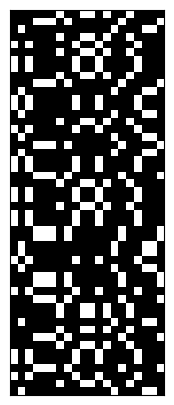

In [9]:
plot_binding_matrix(data)

In [10]:
def encode_dataset_binding(df, miRNA_col, gene_col, label_col):

    # do not forget to shuffle your data so every batch will contain both positive and negative samples
    df = df.sample(frac=1, random_state=42)
    df.reset_index(inplace=True, drop=True)

    max_length_miRNA = df[miRNA_col].map(len).max()
    max_length_gene = df[gene_col].map(len).max()

    binding_samples = binding_encoding(df, miRNA_col=miRNA_col, gene_col=gene_col, tensor_dim=(max_length_gene, max_length_miRNA, 1))
    labels = df[label_col]

    if binding_samples.shape[0] != labels.shape[0]:
        print('sequence and label shapes are different, something went wrong...')

    print(
        'samples',
        binding_samples.shape,
        '\nlabels',
        labels.shape
    )

    return binding_samples, labels

In [11]:
samples_binding, labels = encode_dataset_binding(df, miRNA_col, gene_col, label_col)

samples (32784, 50, 20, 1) 
labels (32784,)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
        samples_binding, labels, test_size=0.1, random_state=42)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (29505, 50, 20, 1)
y_train: (29505,)
X_test: (3279, 50, 20, 1)
y_test: (3279,)


# CNN model

We will use CNN architecture introduced in [Analysis of chimeric reads characterises the diverse targetome of AGO2-mediated regulation](https://doi.org/10.1038/s41598-023-49757-z).

In [13]:
def get_cnn_model(input_shape):
    """
    build model architecture

    return a model object
    """
    cnn_num = 6
    kernel_size = 5
    pool_size = 2
    dropout_rate = 0.3
    dense_num = 2

    x = tf.keras.layers.Input(shape=input_shape,
                       dtype='float32', name='main_input'
                       )
    main_input = x

    for cnn_i in range(cnn_num):
        x = tf.keras.layers.Conv2D(
            filters=32 * (cnn_i + 1),
            kernel_size=(kernel_size, kernel_size),
            padding="same",
            data_format="channels_last",
            name="conv_" + str(cnn_i + 1))(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size), padding='same', name='Max_' + str(cnn_i + 1))(x)
        x = tf.keras.layers.Dropout(rate=dropout_rate)(x)

    x = tf.keras.layers.Flatten(name='2d_matrix')(x)

    for dense_i in range(dense_num):
        neurons = 32 * (cnn_num - dense_i)
        x = tf.keras.layers.Dense(neurons)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(rate=dropout_rate)(x)

    main_output = tf.keras.layers.Dense(1, activation='sigmoid', name='main_output')(x)

    model = K.Model(inputs=[main_input], outputs=[main_output], name='arch_00')

    return model

In [14]:
cnn_model = get_cnn_model(input_shape = X_train.shape[1:])
cnn_model.summary()

Model: "arch_00"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 50, 20, 1)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 50, 20, 32)        832       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 50, 20, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 50, 20, 32)        128       
 Normalization)                                                  
                                                                 
 Max_1 (MaxPooling2D)        (None, 25, 10, 32)        0         
                                                                 
 dropout (Dropout)           (None, 25, 10, 32)        0         
                                                           

In [15]:
cnn_model = compile_model(cnn_model)

In [16]:
history = cnn_model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=15,
    validation_split=0.2
)

Epoch 1/15
738/738 [==============================] - 21s 15ms/step - loss: 0.5579 - accuracy: 0.7268 - val_loss: 1.3818 - val_accuracy: 0.5352
Epoch 2/15
738/738 [==============================] - 10s 14ms/step - loss: 0.3921 - accuracy: 0.8300 - val_loss: 0.3257 - val_accuracy: 0.8632
Epoch 3/15
738/738 [==============================] - 9s 12ms/step - loss: 0.3519 - accuracy: 0.8520 - val_loss: 0.2962 - val_accuracy: 0.8790
Epoch 4/15
738/738 [==============================] - 9s 12ms/step - loss: 0.3277 - accuracy: 0.8650 - val_loss: 0.2792 - val_accuracy: 0.8858
Epoch 5/15
738/738 [==============================] - 10s 13ms/step - loss: 0.3115 - accuracy: 0.8721 - val_loss: 0.2948 - val_accuracy: 0.8800
Epoch 6/15
738/738 [==============================] - 11s 14ms/step - loss: 0.2943 - accuracy: 0.8788 - val_loss: 0.3406 - val_accuracy: 0.8546
Epoch 7/15
738/738 [==============================] - 9s 12ms/step - loss: 0.2842 - accuracy: 0.8841 - val_loss: 0.2635 - val_accuracy: 0.

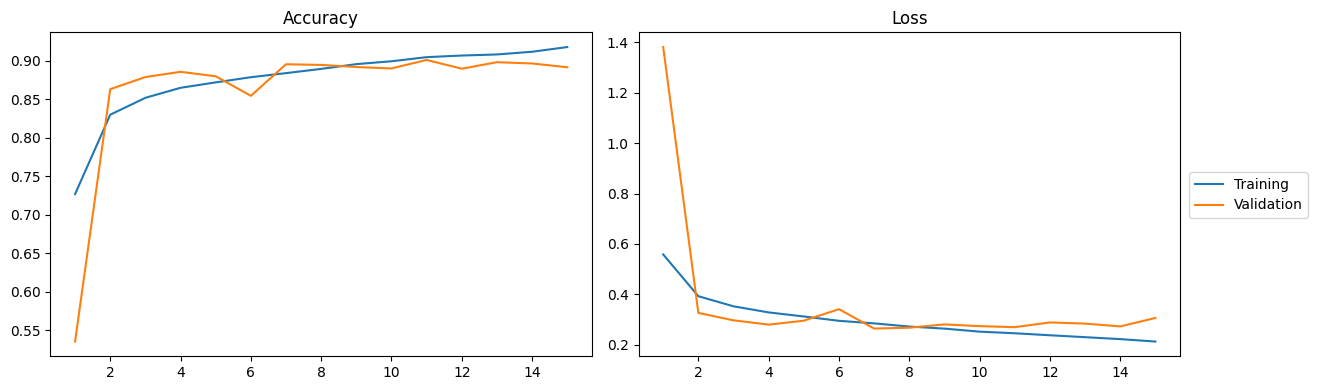

In [17]:
plot_history(history)

# Exercise: Early stopping

We usually do not know for how long we should train our neural network. If we train for too long, our model will start overfitting on training data and will not generalize on test data. One think we can do is use **early stopping** technique - detect we reached the ceiling on validation set and stop the training there.

Explore TensorFlow [tf.keras.callbacks.EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to implement it.